<a href="https://colab.research.google.com/github/OscarTMa/Portfolio-ML/blob/main/training_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %% [markdown]
# # Project 1: Bank Customer Churn Prediction
# **Objective:** Train a Machine Learning model to predict if a customer will leave the bank.
#
# **Tech Stack:**
# * Pandas & NumPy for Data Manipulation
# * Scikit-Learn for Preprocessing
# * SMOTE (Imbalanced-Learn) for balancing the dataset
# * XGBoost for the Classifier
# * Joblib for saving the model


In [2]:

# %%
# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib

import warnings
warnings.filterwarnings('ignore')


In [7]:


# %%
# 2. Load Data
# Make sure 'Churn_Modelling.csv' is in your 'data' folder
try:
    df = pd.read_csv('data/Churn_Modelling.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: CSV file not found. Please download 'Churn_Modelling.csv' from Kaggle.")

# Display first rows
df.head()

# %% [markdown]


Dataset loaded successfully.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:

# ### 3. Data Preprocessing
# We need to clean the data and convert text to numbers so the model can understand it.

# %%
# A. Drop irrelevant columns
# RowNumber, CustomerId, and Surname do not impact the decision to leave.
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# B. Encoding Categorical Variables
# We need to turn 'Gender' and 'Geography' into numbers.
# For this portfolio, we will use Label Encoding for simplicity in the Streamlit App integration.

le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])
# Dictionary to remember: {'Female': 0, 'Male': 1} (Check with le_gender.classes_)

le_geo = LabelEncoder()
df['Geography'] = le_geo.fit_transform(df['Geography'])
# Dictionary to remember: {'France': 0, 'Germany': 1, 'Spain': 2}

print("Data after encoding:")
print(df.head())

# %%
# C. Split into Features (X) and Target (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

# D. Split into Train and Test sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# E. Feature Scaling
# Good practice for Neural Networks, but XGBoost is robust enough without it.
# However, we will scale to keep it standard.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# %% [markdown]



Data after encoding:
   CreditScore  Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619          0       0   42       2       0.00              1   
1          608          2       0   41       1   83807.86              1   
2          502          0       0   42       8  159660.80              3   
3          699          0       0   39       1       0.00              2   
4          850          2       0   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  


In [9]:

# ### 4. Handling Imbalanced Data (SMOTE)
# In Churn datasets, usually only 20% of people leave. If we don't fix this, the model
# might just guess "Stay" for everyone and still get 80% accuracy.
# We use SMOTE (Synthetic Minority Over-sampling Technique) to create fake examples of "churners".

# %%
print(f"Original Class Distribution: \n{y_train.value_counts()}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled Class Distribution: \n{y_train_resampled.value_counts()}")

# %% [markdown]



Original Class Distribution: 
Exited
0    6356
1    1644
Name: count, dtype: int64
Resampled Class Distribution: 
Exited
0    6356
1    6356
Name: count, dtype: int64


In [10]:

# ### 5. Model Training (XGBoost)

# %%
# Initialize XGBoost Classifier
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
model.fit(X_train_resampled, y_train_resampled)
print("Model trained successfully.")

# %% [markdown]



Model trained successfully.


Accuracy Score: 0.8475

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      1607
           1       0.61      0.63      0.62       393

    accuracy                           0.85      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.85      0.85      0.85      2000



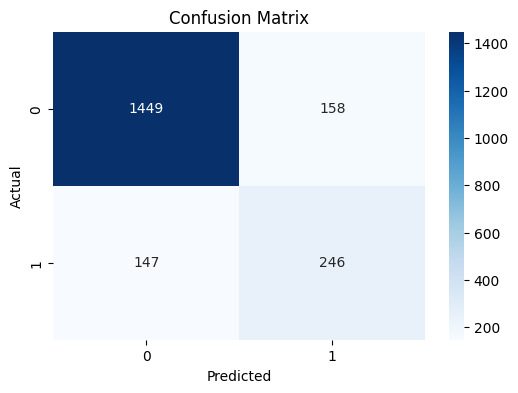

In [11]:

# ### 6. Evaluation
# Let's see how well our model performs on data it has never seen (Test Set).

# %%
y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [12]:


# %% [markdown]
# ### 7. Saving the Artifacts
# We need to save the Model and the Scaler to use them in Streamlit.

# %%
# Create a 'models' directory if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save Model
joblib.dump(model, 'models/churn_xgb_model.pkl')

# Save Scaler (We need to scale the user input in Streamlit exactly like we did here)
joblib.dump(scaler, 'models/churn_scaler.pkl')

print("Model and Scaler saved in 'models/' folder.")

Model and Scaler saved in 'models/' folder.
